<a href="https://colab.research.google.com/github/wellsalexandra/IGM-Phase/blob/main/TDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.cm as cm

Mounted at /content/drive


In [3]:

def get_scaleArr(box):
  """ Return array of all simulated scale factors for a given box

  Kwargs:
  box - char/string of the simulatiom box label (either A,B,C, or F)
  """

  # assign directory
  directory = 'drive/MyDrive/UoM REU Project 2023/igm_phase_data/' + box
  files = np.empty(0)
  # iterate over files in that directory
  for filename in os.scandir(directory):
      if filename.is_file():
        files = np.append(files, filename.path)

  files = np.sort(files)
  index = 0
  scales = np.zeros(len(files))

  #Extract scale factors:
  for i in range(len(files)):
    index = files[i].find("0.")
    strScale = files[i][index:index+6]
    scales[i] = float(strScale)

  return scales


def get_sampleArr(box):
  """ Return array of some simulated scale factors for a given box
  (Smaller array for testing)

  Kwargs:
  box - char/string of the simulatiom box label (either A,B,C, or F)
  """

  directory = 'drive/MyDrive/UoM REU Project 2023/igm_phase_data/' + box
  files = np.empty(0)
  # iterate over files in that directory
  for filename in os.scandir(directory):
      if filename.is_file():
        files = np.append(files, filename.path)

  files = np.sort(files)
  index = 0
  sample = np.empty(0)

  #Extract scale factors:
  for i in range(len(files)):
    if i%5 == 0: # Use every fifth scale factor (Results in array that is 5x smaller than full size)
      index = files[i].find("0.")
      strSample = files[i][index:index+6]
      sample = np.append(sample, float(strSample))

  return sample



In [4]:
### Create full and smaller arrays for each box to use in following cells

A = get_scaleArr('A')
sampleA = get_sampleArr('A')
limit = A>0.12
laterA = A[limit]

B = get_scaleArr('B')
sampleB = get_sampleArr('B')
limit = B>0.12
laterB = B[limit]

C = get_scaleArr('C')
sampleC = get_sampleArr('C')
limit = C>0.12
laterC = C[limit]

F = get_scaleArr('F')
sampleF = get_sampleArr('F')
limit = F>0.12
laterF = F[limit]


In [4]:
### Converts between bin and value

# There are 600 temperature bins that range from log10(T) = 0 to 6 or 10^0 to 10^6 ,
# meaning that each temperature bin corresponds to log10(T) = 0.01 or 10^0.01 (1 bin = 0.01 K)

def temp_bin_to_val(t):
  return t/100.0

def temp_val_to_bin(t):
  return t*100.0

# There are 500 density bings that range from log10(1+delta)= -2 to 3,
# meaning that each density bin corresponds to log10(1+delta)=0.01,
# with bin 200 at log10(1+delta)=0. --> Divide by 100, subtract 2 to get the value from bin

def dens_bin_to_val(d):
  return (d/100.0 - 2.0)

def dens_val_to_bin(d):
  return (d+2.0)*100.0

In [6]:
### Finds and returns the FWHM of the peak temperate
def get_FWHM(box, scale, densityBin):

  arr = np.load("drive/MyDrive/UoM REU Project 2023/igm_phase_data/" + box + "/nT.a=" + str(scale).ljust(6, "0") +".bin.npy")

  tempProb = np.zeros(600)

  for i in range(600):
    tempProb[i] = arr[i, densityBin]

  fullMax = np.max(tempProb)
  fullMaxInd = np.argmax(tempProb) #temperature index of the max probability
  halfMax = fullMax/2.0

  # Can't just use argmax unless I'm specifying a specific range -- We are not separating the modes here -->
  # Method: Start at peak, then iterate to the left until I pass HM. Then repeat to the right

  #Lower T index at HM (iterate from peak to left)
  halfMaxInd1 = 0
  i = fullMaxInd
  while tempProb[i] > halfMax:
    i = i-1

  candidates=np.array([tempProb[i-1], tempProb[i]]) # HM will not necessarily line up with a specific bin, so find the surrounding ones
  if(np.abs(candidates[0]-halfMax) >= np.abs(candidates[1]-halfMax)): #candidate[1] is closer
    halfMaxInd1 = i
  else:
    halfMaxInd1 = i-1

  #Higher T index of HM (iterate from peak to right)
  halfMaxInd2 = 0
  i = fullMaxInd
  while tempProb[i] > halfMax:
    i = i+1

  candidates=np.array([tempProb[i+1], tempProb[i]])
  if(np.abs(candidates[0]-halfMax) >= np.abs(candidates[1]-halfMax)): #candidate[1] is closer
    halfMaxInd2 = i
  else:
    halfMaxInd2 = i+1

  FWHM = np.abs(halfMaxInd2-halfMaxInd1)

  #convert bins to values:
  FWHM = temp_bin_to_val(FWHM)
  halfMaxInd2 = temp_bin_to_val(halfMaxInd2)
  halfMaxInd1 = temp_bin_to_val(halfMaxInd1)

  return [halfMaxInd1, halfMaxInd2, FWHM]


In [7]:
# Can plot the peak temp, returns slope at log10(1+delta)=0
def plot_peakTemp(box, scale, plot, col='blue', subplot=False, ind=-1, overplot=False):

  arr = np.load("drive/MyDrive/UoM REU Project 2023/igm_phase_data/" + box + "/nT.a=" + str(scale).ljust(6, "0") +".bin.npy")
  # sum = np.sum(arr)
  # arr = arr/sum

  densities = np.arange(0, 500)
  temperatures = np.arange(0,600)
  peakTemps = np.zeros(500) # Array of temperature of the peak value for each density

  for i in range(len(peakTemps)):     #for each density
    probs = arr[:, i]                 # Acquire array of probabiliy across temperatures for given density
    index = np.argmax(probs)          # Find temperature bin of maximum probability
    peakTemps[i] = temperatures[index] #Add temperature bin to peak temperature array

  # Narrow the range for plotting (150:300 makes the density range log10(1+delta)= [-0.5, 1]
  densities = densities[150:300]
  peakTemps = peakTemps[150:300]

  #Compute FWHM:
  higherT = np.zeros(len(densities)) #Index 2
  lowerT = np.zeros(len(densities)) #Index 1
  for i in range(len(densities)):
    FWHM = get_FWHM(box, scale, densities[i])
    lowerT[i] = FWHM[0]
    higherT[i] = FWHM[1]

  # Convert bins to actual values
  densities = dens_bin_to_val(densities)
  peakTemps = temp_bin_to_val(peakTemps)

  # Compute polyfit, derivative, and slope at log10(1+delta)=0
  model3 = np.poly1d(np.polyfit(densities, peakTemps, 3))
  derivative = model3.deriv()
  slopeAt0=derivative(0)
  T0 = model3(0)

  # Perhaps useful:
  # residual = np.polyfit(densities, peakTemps, 3, full=True)

  if(plot==True):
    if(subplot==True):
      ax[ind].scatter(densities, peakTemps, s=3, color='blue')

      if(overplot == False): # Not overplotting, so plot the polyfit and FWHM as well
        ax[ind].plot(densities, model3(densities), color='purple', label='3rd Degree Polynomial', alpha=0.7)
        ax[ind].plot(densities, lowerT, color='green')
        ax[ind].plot(densities, higherT, color='green')
        ax[ind].fill_between(densities, lowerT, higherT, alpha=0.2, color= 'green', label='FWHM')

        ax[ind].legend(loc='lower right', fontsize='large')

        ax[ind].set_xlabel("log10(1+δ)", fontsize='xx-large')
        ax[0].set_ylabel("log10(T/K)", fontsize='xx-large')

        ax[ind].annotate("Scale factor = " + str(scale).ljust(6, "0"), [-0.51, 4.33], fontsize=11)
    else: # Not using subplot, don't need axis

      if(overplot == False): # Once again plot polyfit and FWHM, but for when not using subplot
        plt.scatter(densities, peakTemps, s=3, color='blue')
        plt.plot(densities, model3(densities), color='purple', label='3rd Degree Polynomial', alpha=0.7)
        plt.plot(densities, lowerT, color='green')
        plt.plot(densities, higherT, color='green')
        plt.fill_between(densities, lowerT, higherT, alpha=0.2, color= 'green', label='FWHM')
      else: # For when not subplotting, but overplotting (Do not plot polyfit or FWHM)
        plt.scatter(densities, peakTemps, s=3, color=col, label='a=' + str(scale).ljust(6, "0"))


      plt.xlabel("log10(1+δ)", fontsize='xx-large')
      plt.ylabel("log10(T/K)", fontsize='xx-large')
      plt.annotate("Scale factor = " + str(scale).ljust(6, "0"), [-0.5, 4.385], fontsize=11)

  return slopeAt0
  #Case of subplotting AND overplotting is in function subPlot_peak below (working on combining)

In [8]:
def subPlot_peak(box, scale, plot,  col='blue', ind=-1, overplot=False):

  arr = np.load("drive/MyDrive/UoM REU Project 2023/igm_phase_data/" + box + "/nT.a=" + str(scale).ljust(6, "0") +".bin.npy")
  # sum = np.sum(arr)
  # arr = arr/sum

  densities = np.arange(0, 500)
  temperatures = np.arange(0,600)
  peakTemps = np.zeros(500)

  for i in range(len(peakTemps)): #for each density
    probs = arr[:, i]
    index = np.argmax(probs)
    peakTemps[i] = temperatures[index]

  densities = densities[150:300]
  peakTemps = peakTemps[150:300]

  #Compute FWHM:
  higherT = np.zeros(len(densities)) #Index 2
  lowerT = np.zeros(len(densities)) #Index 1
  for i in range(len(densities)):
    FWHM = get_FWHM(box, scale, densities[i])
    lowerT[i] = FWHM[0]
    higherT[i] = FWHM[1]

  # Convert bins to actual values (still log scale???)
  densities = densities/100.0 - 2.0
  peakTemps = peakTemps/100.0

  model3 = np.poly1d(np.polyfit(densities, peakTemps, 3))

  derivative = model3.deriv()
  slopeAt0=derivative(0)

  residual = np.polyfit(densities, peakTemps, 3, full=True)

  if(plot==True):

    ax[ind].scatter(densities, peakTemps, s=3, color=col)
    ax[ind].set_xlabel("log10(1+δ)", fontsize='xx-large')
    ax[0].set_ylabel("log10(T/K)", fontsize='xx-large')

  return model3

In [9]:
def plot_slope(box, density, col, x, subplot=False, ind=-1):

  def scaleToRed(a):
    return 1.0/(a)-1.0

  def redToScale(z):
    return 1.0/(1.0+z)

  #iterate through scale factors of box:
  arr = get_scaleArr(box)
  density = dens_bin_to_val(density)
  neut = np.zeros(0)

  rei = pd.read_csv("drive/MyDrive/UoM REU Project 2023/rei" + box + ".log", sep = "\s+", usecols = [0, 13], names = ["scale", "neutral"], skiprows = 10)
  rei = rei.drop_duplicates(subset=['scale'])

  scales = rei["scale"].to_numpy()
  fracs = rei["neutral"].to_numpy()

  # scales = np.unique(scales)

  for i in range(len(scales)):
    for j in range(len(arr)):
      if(arr[j] == scales[i]): ###Can just add the slice of the length of arr
        # neut = np.append(neut, fracs[i])
        neut = fracs[i: i+len(arr)]
        break

    if(len(neut !=0)):
      break

  np.set_printoptions(threshold = np.inf)
  # print(np.size(scales))
  # print(np.size(arr))

  slopeAt0 = np.zeros(0)
  for i in range(len(arr)):
    der0 = plot_peakTemp(box, arr[i], False)
    slopeAt0 = np.append(slopeAt0, der0)
    # print("Scale factor: " + str(arr[i]) + ", slope: " + str(der0))

  if(box == 'A'):
    name = "Intermediate Reionization 2"
    lines = 'dotted'
  elif(box == 'B'):
    name = "Intermediate Reionization 1"
    lines = 'dashed'
  elif(box == 'C'):
    name = 'Early Reionization'
    lines = 'dashdot'
  elif(box == 'F'):
    name = "Late Reionization"
    lines = 'solid'

  if(subplot==False):
    if(x=='scale'):
      plt.plot(arr, slopeAt0, label=name, linestyle = lines, linewidth = 3, color=col)

      #For non log scale x axis:
      plt.xlim(0.12, 0.17)
      plt.ylim(-0.2, 0.4)
      plt.xlabel(xlabel='Scale Factor', fontsize='xx-large')

    elif(x=='neutral'):
      plt.plot(neut, slopeAt0, label=name, linestyle = lines, linewidth = 3, color=col)

      # For log neutral x axis:
      plt.xlim(0, 0.6)
      # # plt.ylim(-0.5, 1)
      plt.ylim(-0.2,0.375)
      plt.xscale('log')
      plt.xlabel(xlabel='Neutral Fraction', fontsize='xx-large')

    plt.legend(loc='best', fontsize='x-large', framealpha=0.5)
    # plt.title("Slope of Peak Temperature at " + str(density) + "<log10(1+δ)<" + str(density+0.01), fontsize='xx-large')
    plt.xticks()
    plt.ylabel(ylabel="Slope", fontsize='xx-large')
    plt.yticks()

  else:
    if(x=='scale'):

      ax[ind].plot(arr, slopeAt0, label=name, linestyle = lines, linewidth = 3, color=col)

      if(box == 'C'):
        secax = ax[ind].secondary_xaxis('top', functions=(scaleToRed, redToScale))
        secax.set_xlabel('Redshift', fontsize='xx-large')

      #For non log scale x axis:
      ax[ind].set_xlim(0.11, 0.17)
      ax[ind].set_ylim(-0.2, 0.4)
      ax[ind].set_xlabel(xlabel='Scale Factor', fontsize='xx-large')

    elif(x=='neutral'):
      ax[ind].plot(neut, slopeAt0, label=name, linestyle = lines, linewidth = 3, color=col)

      # For log neutral x axis:
      ax[ind].set_xlim(0, 0.6)
      # plt.ylim(-0.5, 1)
      ax[ind].set_ylim(-0.2,0.375)
      ax[ind].set_xscale('log')
      ax[ind].set_xlabel(xlabel='Neutral Fraction', fontsize='xx-large')

    ax[ind].legend(loc='best', fontsize='large', framealpha=0.5)
    # ax[ind].set_title("Slope of Peak Temperature", fontsize='xx-large')
    ax[ind].set_ylabel(ylabel="Slope", fontsize='xx-large')




In [10]:
#Takes density BIN
def plot_FWHM(box, density, col, x, subplot=False, ind=-1):

  # density = density/1.0 #From plot_slope ... why different?

  def scaleToRed(a):
    return 1.0/(a)-1.0

  def redToScale(z):
    return 1.0/(1.0+z)

  arr = get_scaleArr(box)
  # Get redshift array
  redshift = np.zeros(0)
  for i in range(len(arr)):
    # if(i % 5 == 0):
    r = np.around((1.0/arr[i])-1.0, 0)
    redshift = np.append(redshift, r)


  # get T0:



  FWHM = np.zeros(0)

  for i in range(len(arr)):
    temp = get_FWHM(box, arr[i], density) #density used
    FWHM = np.append(FWHM, temp[2])

  density = density/100.0 - 2.0 #For printing the non-bin value below
  neut = np.zeros(0)

  rei = pd.read_csv("drive/MyDrive/UoM REU Project 2023/rei" + box + ".log", sep = "\s+", usecols = [0, 13], names = ["scale", "neutral"], skiprows = 10)
  rei = rei.drop_duplicates(subset=['scale'])

  scales = rei["scale"].to_numpy()
  fracs = rei["neutral"].to_numpy()

  # scales = np.unique(scales)

  for i in range(len(scales)):
    for j in range(len(arr)):
      if(arr[j] == scales[i]): ###Can just add the slice of the length of arr
        # neut = np.append(neut, fracs[i])
        neut = fracs[i: i+len(arr)]
        break

    if(len(neut !=0)):
      break

  if(box == 'A'):
    name = "Intermediate Reionization 2"
    lines = 'dotted'
  elif(box == 'B'):
    name = "Intermediate Reionization 1"
    lines = 'dashed'
  elif(box == 'C'):
    name = 'Early Reionization'
    lines = 'dashdot'
  elif(box == 'F'):
    name = "Late Reionization"
    lines = 'solid'


  if(subplot==False):

    if(x=='scale'):
      plt.plot(arr, FWHM, label=name, linestyle=lines, linewidth=3, color=col)

      # For non-log scale factor x axis:
      plt.xlim(0.11, 0.17)
      plt.ylim(0.025, 0.3)
      plt.xlabel(xlabel='Scale Factor', fontsize='xx-large')
    elif(x=='neutral'):
      plt.plot(neut, FWHM, label=name, linestyle=lines, linewidth=3, color=col)

      #For log neutral x axis:
      plt.xlim(0, 0.6)
      plt.ylim(0.025, 0.23)
      plt.xscale('log')
      plt.xlabel(xlabel='Neutral Fraction', fontsize='xx-large')

    plt.legend(loc="best", fontsize='x-large', framealpha=0.5)
    # plt.title("FWHM of Peak Temperature at " + str(density) + "<log10(1+δ)<" + str(density+0.01), fontsize='xx-large')
    plt.xticks()
    plt.ylabel(ylabel="FWHM", fontsize='xx-large')
    plt.yticks()

  else:
    if(x == 'scale'):
      ax[ind].plot(arr, FWHM, label=name, linestyle=lines, linewidth=3, color=col)

      ## ATTEMPT REDSHIFT AXIS HERE:
      # ax2 = ax[ind].twiny()
      # plott = np.arange(redshift[len(redshift)-1], redshift[0],  2)
      # plott = np.flip(plott)
      # ax2.set_xticks(plott)
      # ax2.set_xticklabels(plott[::-1])
      # ax2.set_xlabel("Redshift")
      # ax2.plot(redshift, FWHM, label=name, linestyle=lines, linewidth=3, color=col)
      # ???

      if(box == 'C'):
        secax = ax[ind].secondary_xaxis('top', functions=(scaleToRed, redToScale))
        secax.set_xlabel('Redshift', fontsize='xx-large')

      #For non-log scale factor x axis:
      ax[ind].set_xlim(0.11, 0.17)
      ax[ind].set_ylim(0.025, 0.3)
      ax[ind].set_xlabel(xlabel='Scale Factor', fontsize='xx-large')
    elif(x=='neutral'):
      ax[ind].plot(neut, FWHM, label=name, linestyle=lines, linewidth=3, color=col)
      # ax2 = ax[ind].twiny()
      # plott = np.arange(redshift[len(redshift)-1], redshift[0],  2)
      # plott = np.flip(plott)
      # ax2.set_xticks(plott)
      # ax2.set_xlabel("Redshift")
      # ax2.plot(redshift, FWHM, label=name, linestyle=lines, linewidth=3, color=col)

      #For log neutral x axis:
      ax[ind].set_xlim(0, 0.6)
      ax[ind].set_ylim(0.04, 0.23)
      ax[ind].set_xscale('log')
      ax[ind].set_xlabel(xlabel='Neutral Fraction', fontsize='xx-large')

    ax[ind].set_ylabel(ylabel="FWHM", fontsize='xx-large')
    ax[ind].legend(loc="best", fontsize='large', framealpha=0.5)
    # ax[ind].set_title("FWHM of Peak Temperature", fontsize='xx-large')

    # ax[ind].set_yticks()


In [11]:
# Can plot the peak temp, returns slope at log10(1+delta)=0
def get_meanPeakTemp(box, scale):

  arr = np.load("drive/MyDrive/UoM REU Project 2023/igm_phase_data/" + box + "/nT.a=" + str(scale).ljust(6, "0") +".bin.npy")
  # sum = np.sum(arr)
  # arr = arr/sum

  densities = np.arange(0, 500)
  temperatures = np.arange(0,600)
  peakTemps = np.zeros(500) # Array of temperature of the peak value for each density

  for i in range(len(peakTemps)):     #for each density
    probs = arr[:, i]                 # Acquire array of probabiliy across temperatures for given density
    index = np.argmax(probs)          # Find temperature bin of maximum probability
    peakTemps[i] = temperatures[index] #Add temperature bin to peak temperature array

  # Narrow the range for plotting (150:300 makes the density range log10(1+delta)= [-0.5, 1]
  densities = densities[150:300]
  peakTemps = peakTemps[150:300]

  # Convert bins to actual values
  densities = dens_bin_to_val(densities)
  peakTemps = temp_bin_to_val(peakTemps)

  # Compute polyfit, derivative, and slope at log10(1+delta)=0
  model3 = np.poly1d(np.polyfit(densities, peakTemps, 3))
  T0 = model3(0)
  return T0



In [12]:
def plot_meanPeakTemp(box, density, col, x, subplot=False, ind=-1):

  def scaleToRed(a):
    return 1.0/(a)-1.0

  def redToScale(z):
    return 1.0/(1.0+z)

  arr = get_scaleArr(box)

  temps = np.zeros(0)

  for i in range(len(arr)):
    T = get_meanPeakTemp(box, arr[i])
    temps = np.append(temps, T)

  density = density/100.0 - 2.0 #For printing the non-bin value below
  neut = np.zeros(0)

  rei = pd.read_csv("drive/MyDrive/UoM REU Project 2023/rei" + box + ".log", sep = "\s+", usecols = [0, 13], names = ["scale", "neutral"], skiprows = 10)
  rei = rei.drop_duplicates(subset=['scale'])

  scales = rei["scale"].to_numpy()
  fracs = rei["neutral"].to_numpy()

  for i in range(len(scales)):
    for j in range(len(arr)):
      if(arr[j] == scales[i]): ###Can just add the slice of the length of arr
        # neut = np.append(neut, fracs[i])
        neut = fracs[i: i+len(arr)]
        break

    if(len(neut !=0)):
      break

  if(box == 'A'):
    name = "Intermediate Reionization 2"
    lines = 'dotted'
  elif(box == 'B'):
    name = "Intermediate Reionization 1"
    lines = 'dashed'
  elif(box == 'C'):
    name = 'Early Reionization'
    lines = 'dashdot'
  elif(box == 'F'):
    name = "Late Reionization"
    lines = 'solid'

  if(x == 'scale'):
    ax[ind].plot(arr, temps, label=name, linestyle=lines, linewidth=3, color=col)

    if(box == 'C'):
      secax = ax[ind].secondary_xaxis('top', functions=(scaleToRed, redToScale))
      secax.set_xlabel('Redshift', fontsize='xx-large')

    #For non-log scale factor x axis:
    ax[ind].set_xlim(0.11, 0.17)
    ax[ind].set_ylim(4, 4.4)
    ax[ind].set_xlabel(xlabel='Scale Factor', fontsize='xx-large')

  elif(x == 'neutral'):
    ax[ind].plot(neut, temps, label=name, linestyle=lines, linewidth=3, color=col)

    #For log neutral x axis:
    ax[ind].set_xlim(0, 0.6)
    ax[ind].set_ylim(4, 4.3)
    ax[ind].set_xscale('log')
    ax[ind].set_xlabel(xlabel='Neutral Fraction', fontsize='xx-large')


  ax[ind].set_ylabel(ylabel="Temperature", fontsize='xx-large')
  ax[ind].legend(loc="best", fontsize='large', framealpha=0.5)




4.207468136490876
4.126745951060061
4.087213659315615


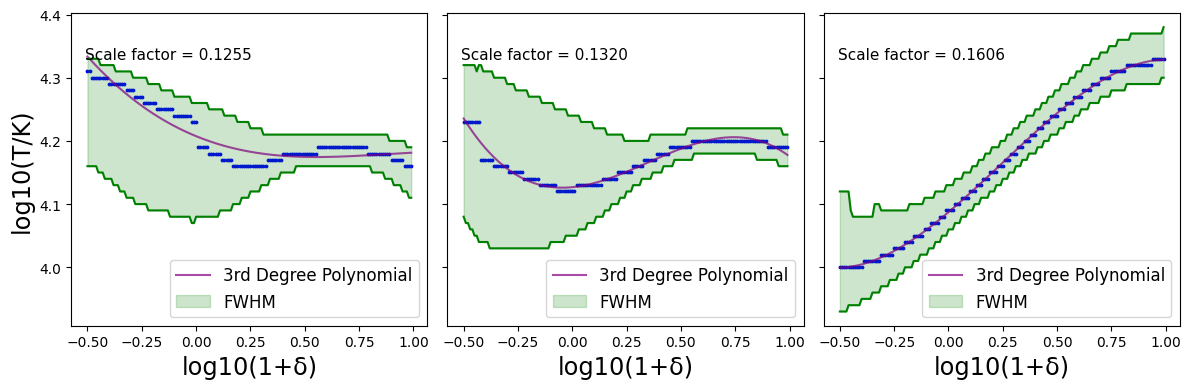

In [ ]:

fig, ax = plt.subplots(ncols=3, figsize=(12, 4), sharey=True, sharex=True)
# plot_peak('B', 0.1249, plot=True, ind=0)
# plot_peak('B', 0.1430, plot=True, ind=1)
# plot_peak('B', 0.1609, plot=True, ind=2)

# plot_peakTemp('B', 0.1430, plot=True, col='blue', ind=0, overplot=False, subplot=True)
# plot_peakTemp('B', 0.1511, plot=True, col='blue', ind=1, overplot = False, subplot=True)
# plot_peakTemp('B', 0.1609, plot=True, col='blue', ind=2, overplot=False, subplot=True)

plot_peakTemp('F', 0.1255, plot=True, col='blue', ind=0, overplot=False, subplot=True)
plot_peakTemp('F', 0.1320, plot=True, col='blue', ind=1, overplot = False, subplot=True)
# # plot_peakTemp('F', 0.1401, plot=True, col='blue', ind=2, overplot=False) #1312
# plot_peakTemp('F', 0.1329, plot=True, col='blue', ind=2, overplot=False, subplot=True)
plot_peakTemp('F', 0.1606, plot=True, col='blue', ind=2, overplot=False, subplot=True)


# plot_peakTemp('A', 0.1124, plot=True, col='blue', subplot=True, ind=0, overplot=False)
# plot_peakTemp('C', 0.1120, plot=True, col='blue', subplot=True, ind=1, overplot = False)

plt.tight_layout()
plt.show(fig)


<ipython-input-57-940fbc9a7c43>:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Scale Factor')


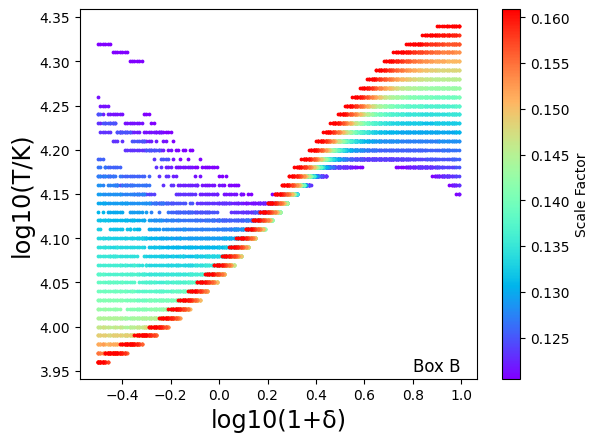

In [ ]:
#Plot peak temp at all (later) scale factors on one plot and use cmap
fig, axis = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, len(laterB)))
for a, c in zip(laterB, colors):
  plot_peakTemp('B', a, plot=True, col=c, ind=-1, overplot=True)

sm = plt.cm.ScalarMappable(cmap='rainbow', norm=plt.Normalize(vmin=laterB[0], vmax=laterB[len(laterB)-1]))
plt.annotate("Box B", [0.8, 3.95], fontsize='large')
plt.colorbar(sm, label='Scale Factor')

plt.show(fig)



<ipython-input-53-8fd710eca380>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


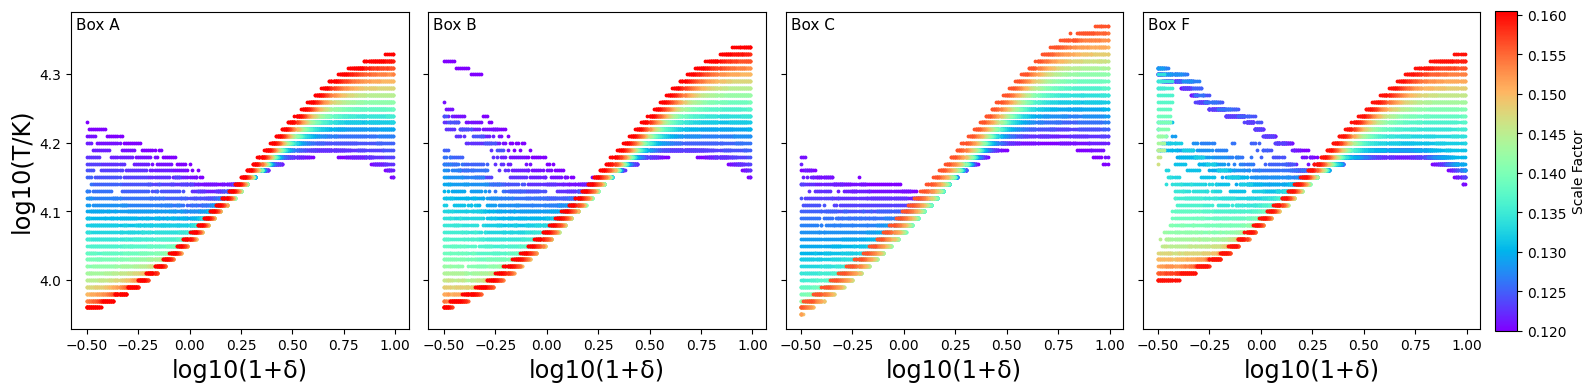

In [ ]:
#Plot peak temp at all scale factors on one plot (overplot), for each box (Four columned subplot)
fig, ax = plt.subplots(ncols=4, figsize=(15, 4), sharey=True, sharex=True)

colors = cm.rainbow(np.linspace(0, 1, len(laterB))) ### Colors based on one box -- doesn't matter?

for a, c in zip(laterA, colors):
  subPlot_peak('A', a, plot=True, col=c, ind=0, overplot=True)

for a, c in zip(laterB, colors):
  subPlot_peak('B', a, plot=True, col=c, ind=1, overplot=True)

for a, c in zip(laterC, colors):
  subPlot_peak('C', a, plot=True, col=c, ind=2, overplot=True)

for a, c in zip(laterF, colors):
  subPlot_peak('F', a, plot=True, col=c, ind=3, overplot=True)

sm = plt.cm.ScalarMappable(cmap='rainbow', norm=plt.Normalize(vmin=0.12, vmax=0.1605))
# plt.colorbar(sm, label='Scale Factor', ax=ax[0])
# plt.colorbar(sm, label='Scale Factor', ax=ax[1])
# plt.colorbar(sm, label='Scale Factor', ax=ax[2])
ax[0].annotate(("Box A"), [-0.55, 4.365], fontsize=11)
ax[1].annotate(("Box B"), [-0.55, 4.365], fontsize=11)
ax[2].annotate(("Box C"), [-0.55, 4.365], fontsize=11)
ax[3].annotate(("Box F"), [-0.55, 4.365], fontsize=11)

cbar_width = 0.015
cbar_height = 0.8
cbar_xpos = 1.0  # The x-position of the colorbar (1.0 = far right of the figure)
cbar_ypos = 0.165  # The y-position of the colorbar (0.0 = bottom of the figure)

# Define the position of the colorbar [left, bottom, width, height]
cbar_pos = [cbar_xpos, cbar_ypos, cbar_width, cbar_height]

# Add the colorbar to the figure
fig.colorbar(sm, cax=fig.add_axes(cbar_pos), label='Scale Factor')

plt.subplots_adjust(wspace=0, hspace=0)

# axis.margins(0.25, 5)
# plt.xlim(-0.5, 1)
# plt.ylim(3.9, 4.4)
plt.tight_layout()
plt.show(fig)


0.18975452456918784

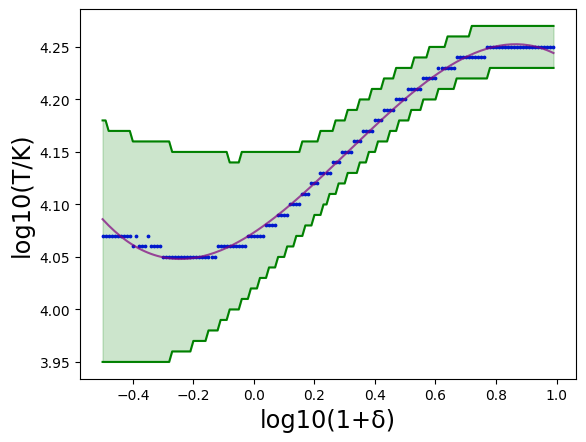

In [ ]:
plot_peakTemp('B', 0.1359, plot=True)

In [ ]:
# plot_slope('A', 200, 'blue', x='scale')
# plot_slope('B', 200, 'orange', x='scale')
# plot_slope('C', 200, 'green', x='scale')
plot_slope('F', 200, 'red', x='scale')
plt.show()

<ipython-input-47-be46ca3caa3a>:57: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 0.6)
<ipython-input-47-be46ca3caa3a>:57: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 0.6)
<ipython-input-47-be46ca3caa3a>:57: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 0.6)


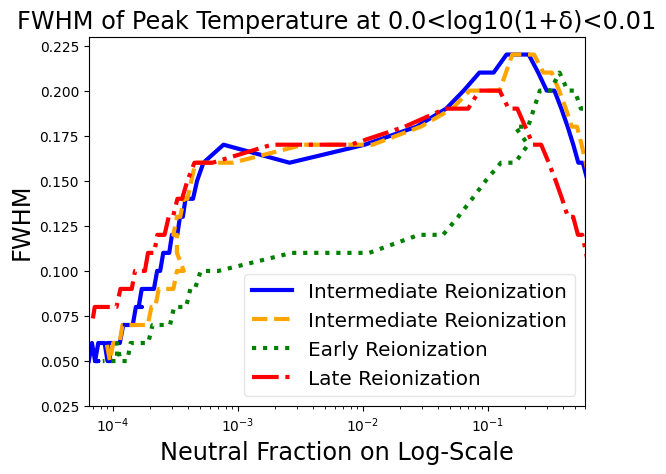

In [ ]:
plot_FWHM('A', 200, 'blue', x='scale')
plot_FWHM('B', 200, 'orange',x='scale')
plot_FWHM('C', 200, 'green',x='scale')
plot_FWHM('F', 200, 'red',x='scale')



plt.show()

<ipython-input-9-92058b5e26aa>:98: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[ind].set_xlim(0, 0.6)
<ipython-input-9-92058b5e26aa>:98: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[ind].set_xlim(0, 0.6)
<ipython-input-9-92058b5e26aa>:98: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[ind].set_xlim(0, 0.6)
<ipython-input-10-f288f31c29e7>:122: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[ind].set_xlim(0, 0.6)
<ipython-input-10-f288f31c29e7>:122: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[ind].set_xlim(0, 0.6)
<ipython-input-10-f288f31c29e7>:122: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[ind].set_xlim(0, 0.6)
<ipython-input-12-4a39d3ca5ac6>:65: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored

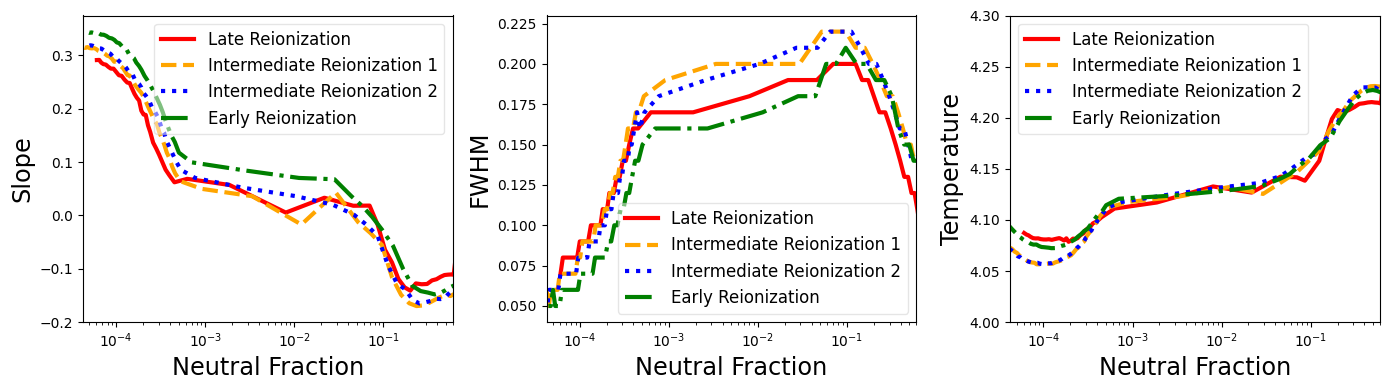

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4), sharey=False, sharex=False)

# def scaleToRed(a):
#   return 1.0/(a)-1.0

# def redToScale(z):
#   return 1.0/(1.0+z)

# secax1 = ax[0].secondary_xaxis('top', functions=(scaleToRed, redToScale))
# secax2 = ax[1].secondary_xaxis('top', functions=(scaleToRed, redToScale))
# secax1.set_xlabel('Redshift (z)')
# secax2.set_xlabel('Redshift (z)')


plot_slope('F', 200, 'red', x='neutral', subplot=True, ind=0)
plot_slope('B', 200, 'orange', x='neutral', subplot=True, ind =0)
plot_slope('A', 200, 'blue', x='neutral', subplot=True, ind=0)
plot_slope('C', 200, 'green', x='neutral', subplot=True, ind=0)

plot_FWHM('F', 200, 'red', x='neutral', subplot=True, ind=1)
plot_FWHM('B', 200, 'orange', x='neutral', subplot=True, ind=1)
plot_FWHM('A', 200, 'blue', x='neutral', subplot=True, ind=1)
plot_FWHM('C', 200, 'green', x='neutral', subplot=True, ind=1)

plot_meanPeakTemp('F', 200, 'red', x='neutral', subplot=True, ind=2)
plot_meanPeakTemp('B', 200, 'orange', x='neutral', subplot=True, ind=2)
plot_meanPeakTemp('A', 200, 'blue', x='neutral', subplot=True, ind=2)
plot_meanPeakTemp('C', 200, 'green', x='neutral', subplot=True, ind=2)

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show(fig)

In [ ]:
### CELLS BELOW ARE MORE FOR TESTING/CHECKING PURPOSES (NOT IMPORTANT)

In [ ]:
#iterate through density find peak
def get_peakTemp(box, scale, density):

  arr = np.load("drive/MyDrive/UoM REU Project 2023/igm_phase_data/" + box + "/nT.a=" + str(scale).ljust(6, "0") +".bin.npy")

  temperatures = np.arange(0,600)

  probs = arr[:, density]
  index = np.argmax(probs)
  peakTemp = temperatures[index]
  # peakTemp = peakTemp/100.0

  return peakTemp



Text(0.5, 1.0, 'Peak Temperature overtime for log10(1+δ)=-0.3')

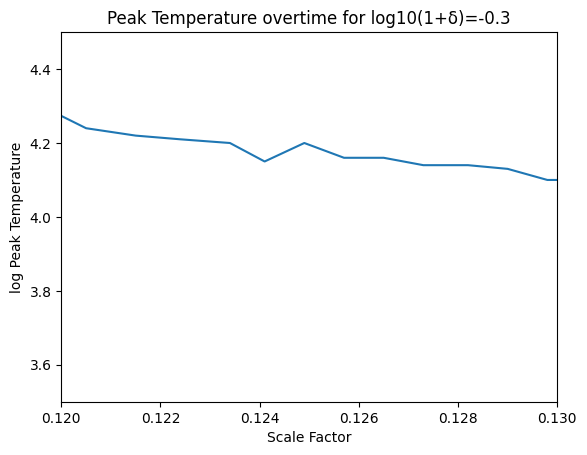

In [ ]:
peakTemps = np.zeros(0)
for i in range(len(B)):
  peakTemps = np.append(peakTemps, get_peakTemp('B', B[i], 170))

plt.plot(B, peakTemps)
plt.xlabel("Scale Factor")
plt.xlim(0.12, 0.13)
plt.ylim(3.5, 4.5)
plt.ylabel("log Peak Temperature")
plt.title("Peak Temperature overtime for log10(1+δ)=-0.3")

In [ ]:
#plot subplot of 3 histograms of (temp, prob) for 3 diff densities
def plot_subplotHist(box, scale, density, index):


  arr = np.load("drive/MyDrive/UoM REU Project 2023/igm_phase_data/" + box + "/nT.a=" + str(scale).ljust(6, "0") +".bin.npy")
  sum = np.sum(arr)
  arr = arr/sum


  tempProb = np.zeros(600)

  for i in range(600):
    tempProb[i] = arr[i, density]

  x = np.linspace(0, 6, 600)
  axis[index].bar(x, tempProb, align = 'edge', width = 0.01, color = 'blue', alpha = 0.7)

  fullMax = np.max(tempProb)
  halfMax = fullMax/2.0

  FWHM = get_FWHM(box, scale, density)
  lowerT = FWHM[0]
  higherT = FWHM[1]

  axis[index].hlines(halfMax, lowerT, higherT, color='red')
  axis[index].vlines(lowerT, 0, halfMax, color = 'red')#, linestyles = 'dashed')
  axis[index].vlines(higherT, 0, halfMax, color = 'red')#, linestyles = 'dashed')



  axis[index].set_xlabel("Temperature (log10(T/K))", fontsize='xx-large')
  axis[index].set_ylabel("Probability on log-scale", fontsize='xx-large')
  axis[index].set_yscale('log')
  axis[index].set_title("Density: log10(1+d) = " + str(density/100.0-2.0))
  # axis[index].set_ylim((10**-6,10**-3) )
  axis[index].set_xlim(1, 5)




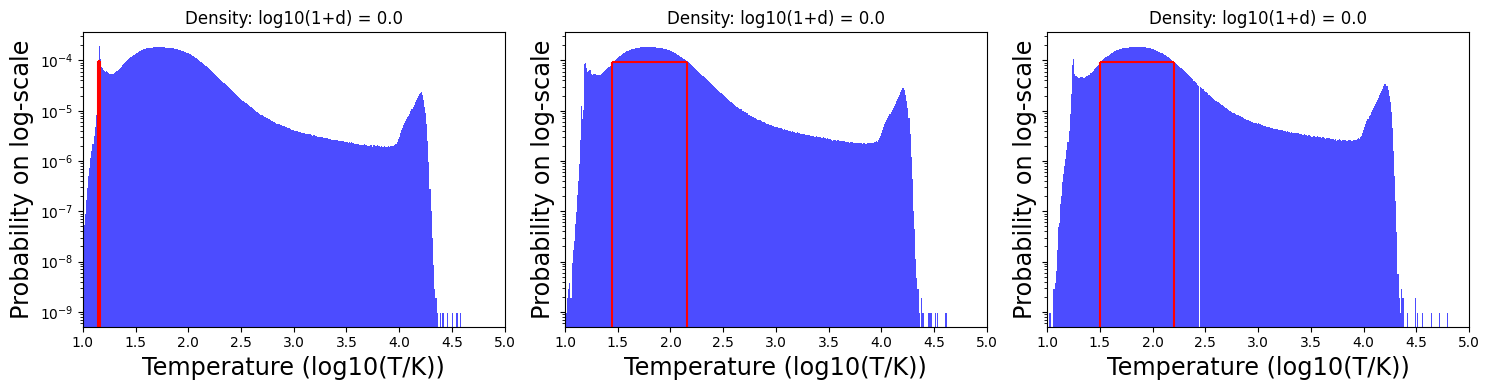

In [ ]:
fig, axis = plt.subplots(ncols=3, figsize=(15, 4), sharey=True, sharex=True)

# plot_subplotHist('B', 0.1430, 109, 0)
# plot_subplotHist('B', 0.1430, 200, 1)
# plot_subplotHist('B', 0.1430, 300, 2)

plot_subplotHist('B', 0.0945, 200, 0)
plot_subplotHist('B', 0.0954, 200, 1)
plot_subplotHist('B', 0.0962, 200, 2)


plt.tight_layout()
plt.show()

(3.9, 4.3)

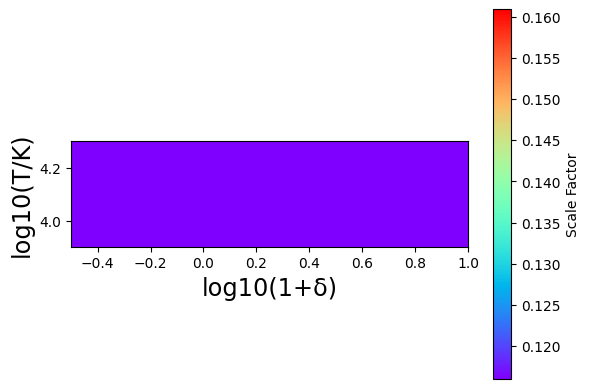

In [ ]:
#Create 2D 150(dense)x600(temp) array
#Iterate through scale factors:
#For each scale factor, iterate through each density
#For each density, calculate the peak temp.
#Multiply peak temp by 100 to get the bin number

# array[i, peakTempBin] = scale

arr = np.zeros([500, 600])

# for i in range(len(laterB)):
for j in range(len(arr[:, 0])): #iterate through densities
    # peakT = get_peakTemp('B', laterB[i], j)
  peakT = get_peakTemp('B', 0.1609, j)
    # peakT = peakT*100
  # print(peakT)

  arr[j, peakT] = 0.1609

# for i in range(len(arr[:, 0])):
#   for j in range(len(arr[0, :])):
#     print(arr[i, j])

map = plt.imshow(arr, extent = [-2, 3, 0, 6], origin = 'lower', vmin = laterB[0], vmax=laterB[len(laterB)-1], cmap = 'rainbow')
# cb = fig.colorbar(mappable = map)
# cb.set_label(label="log10(Probabilty)", fontsize='xx-large')
plt.colorbar(label='Scale Factor')
#fig.colorbar.update_normal(mappable = map, label = 'log probability')
plt.xlabel("log10(1+δ)", fontsize='xx-large')
plt.ylabel("log10(T/K)", fontsize='xx-large')
plt.xlim(-0.5, 1)
plt.ylim(3.9, 4.3)
# plt.title("Phase Diagram for Scale Factor a = " + str(scale).ljust(6, "0"), fontsize='xx-large')



<ipython-input-101-22b5e881ad5c>:8: RuntimeWarning: divide by zero encountered in log10
  map = plt.imshow(np.log10(arr), extent = [-2, 3, 0, 6], origin = 'lower', vmin = -8, vmax =-2)


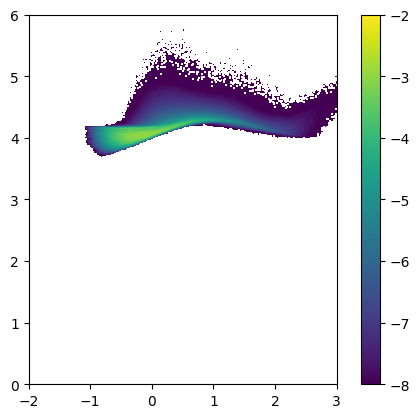

In [ ]:
arr = np.load("drive/MyDrive/UoM REU Project 2023/igm_phase_data/" + 'B' + "/nT.a=" + str(0.1430).ljust(6, "0") +".bin.npy")

sum = np.sum(arr)
arr = arr/sum

# densities = np.arange(0, 500)

map = plt.imshow(np.log10(arr), extent = [-2, 3, 0, 6], origin = 'lower', vmin = -8, vmax =-2)
plt.colorbar(mappable = map)
# plt.ylim(4.5, 6.5)